In [28]:
from utils import *
from fastai2.vision.widgets import *
from fastai2.vision.all import *

# from fastai2.vision import *
# from fastai2.vision.utils import *
# from fastai2.imports import *
# from fastai2.data import *
# from fastai2.data.transforms import *
# from fastai2.data.block import *

In [19]:
# Set matplotlib default plot size: 
mpl.rcParams['figure.figsize'] = [16,10]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

NameError: name 'mpl' is not defined

# Squash Classifier

I love winter squash. I typically hate summer squash. This classifier will help me make sure that I never accidentally purchase a zucchini squash when what I really want is an acorn squash.

# Take-aways from this lesson:
1. DO NOT expect the fast-ai course to be organized. For any given task you would like to complete, there are at least 3 different "official" resources that may be contradictory or outdated:

    - Video Lectures
    - The Jupyter Notebooks that accompanying the lessons
    - The Course web-page. 
    - And sometimes slack and the fast.ai official forums. 

All four of these resources are likely to give you conflicting instructions and resources mentioned in video lectures are often not found on the course website.

2. Clean your data by hand if the ImageCleaner isn't providing good results. It's likely that the top losses do not contain a good picture of your noisy data. 

In [2]:
path = Path('data/squash')

In [3]:
types = ['butternut', 'pumpkin', 'acorn', 'zucchini', 'tromboncino', 'spaghetti', 'kabocha', 'patty', 'red kuri', 'sweet dumpling']

In [13]:
# create directories for training data
for type in types:
    folder = type
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [4]:
# make sure all my directories are in place
path.ls()

(#17) [Path('data/squash/red kuri.txt'),Path('data/squash/pumpkin'),Path('data/squash/pumpkin.txt'),Path('data/squash/tromboncino.txt'),Path('data/squash/acorn.txt'),Path('data/squash/spaghetti.txt'),Path('data/squash/tromboncino'),Path('data/squash/.ipynb_checkpoints'),Path('data/squash/acorn'),Path('data/squash/butternut.txt')...]

In [5]:
for type in types:
    download_images(path/f'{type}/', path/f'{type}.txt')    

In [6]:
file_names = get_image_files(path)
len(file_names)

2816

In [7]:
# verify all the URLs work and the images aren't broken:
failed = verify_images(file_names)
len(failed)

0

In [ ]:
# Delete any files that are found to be corrupt. 
failed.map(Path.unlink)

## DataBlocks, DataLoader and DataLoaders

__DataBlock:__ A template for splitting and transforming data for feeding into a Machine Learning model. It includes instructions on how to do the following:
   - How to split independent and dependant variables
   - How to obtain the data (from a file, for example)
   - How to split the data between training and validation
   - How to get the labels (for example, from the folder name containing images for a specific class).
   - How to transform the data (crop, resize, flip, rotate, etc.)

__DataLoader:__ The formatted data that is being used by our model, for example formatted training data. 

__DataLoaders (Plural) :__ A container of `DataLoader` objects. For example a training DataLoader and a validation DataLoader

A Datablock is a template from which a DataLoaders (plural) is cut. In order to create a `DataLoaders` object, we need to format actual data, based on a DataBlock template. So, step one is to create a DataLoader with all of our preferences defined:

In [8]:
# Create a DataBlock object. 
squash = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=333),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Then, After creating our `DataBlock` template, we can use it to format our image data into a `DataLoaders` object by passing it some actual image data:

In [9]:
dls = squash.dataloaders(path)

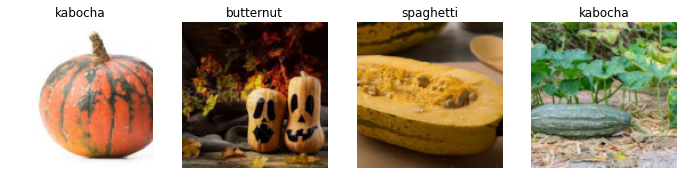

In [10]:
# show batch of images our images.
dls.train.show_batch(max_n=4, nrows=1)

There are multiple methods we can use for resizing our images so that they are all uniform. In the method above, we simply cropped them from the center, into dimensions of 128 by 128.

However, this may cause loss of important features in the photos, so we have several other methods which address this.
- Squish: squishes ALL of the image data into a square. This one distorts our images perhaps to the point where they are unrealistic for machine learnin purposes.
- Pad: Adds a frame around images that are not square. This addressses the distortion problems caused by the `Squish` method, but adds unecissary data that our model will have to deal with. 
- RandomResizeCrop: Currently the best solution, which is to randomly crop and resize each photo so that the model gets to learn from multiple different 'views' of the same 'object'. Imagine holding an unknown piece of fruit in your hand and turning it over to get a different perspective on it.  

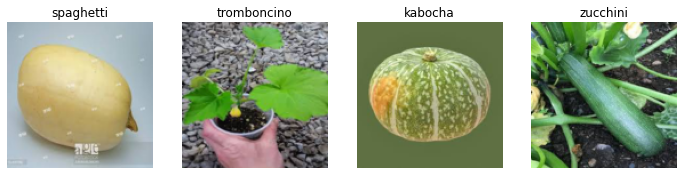

In [11]:
# With the 'Squish' method:
squash = squash.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = squash.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

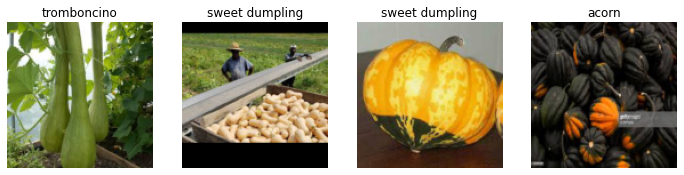

In [12]:
# With the 'Pad' method:
squash = squash.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = squash.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

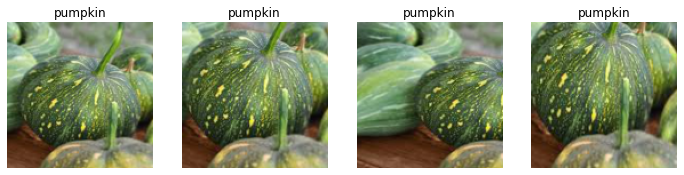

In [13]:
# With the 'RandomResizeCrop' method:
squash = squash.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = squash.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

In the above example, we used the argument `item_tfms`to transform each item in the entire dataset to have uniform size and dimensions. We can use a different argument `batch_tfms` to perform _data augmentation_ randomly to batches as they are passed from our `DataLoaders` object to our neural net. This allows the neural net to get different a different perspective of each image, each time it sees that image:

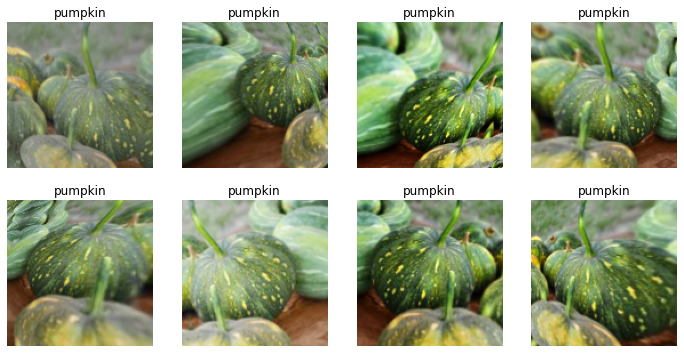

In [14]:
squash = squash.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = squash.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

### Training a Model:

Now that we know how to standardize the shape and size of our data, as well as give a neural network different views of the same data, let's put it all together by creating and training a neural net.

In [15]:
# Create a new DataBlock (using the old one)
squash = squash.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()    
)

In [16]:
# Create a DataLoaders object from our DataBlock template:
loaders = squash.dataloaders(path) 

In [17]:
# create CNN. This CNN's top losses will be used to clean the image data:
learner = cnn_learner(loaders, resnet34, metrics=error_rate)

In [100]:
# learner.fine_tune essentially fits the model for a cycle, tunes some parameters, unfreezes and then fits some more. 
# It is the equivilent of running learner.fit_one_cycle(1), learner.unfreeze(), then learner.fit_one_cycle(1) again. 
learner.fine_tune??

In [18]:
# Fine tune the model:
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.572063,1.462316,0.399645,03:43


epoch,train_loss,valid_loss,error_rate,time
0,1.461573,1.255555,0.341030,05:13
1,1.266110,1.245909,0.330373,05:09
2,1.031411,1.173288,0.300178,05:14
3,0.799217,1.183859,0.294849,05:16
4,0.648460,1.174673,0.298401,05:15


Let's interpret our models performance. We will do this by using a confusion matrix to see what the most commonly mis-identified squash are. 

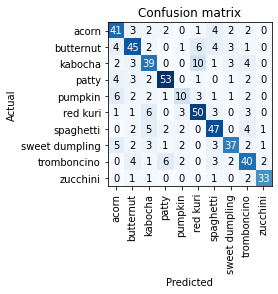

In [20]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

It looks like our main culprit is the pumpkin/acorn squash types. Let's also take a look at our _top losses_. 

### But wait, what is loss?

Loss is a term that describes how wrong our model was in its predictions. For example, if the neural net predicted that a certain image had 99% probability of being a pumpkin, but that image was actually of a zucchini, then loss would be very high. However, if it predicted that image was of a pumpkin with only 55% probability, but the image was actually a zucchini, then loss would be lower. 

Let's take a look at those images with the greatest loss:

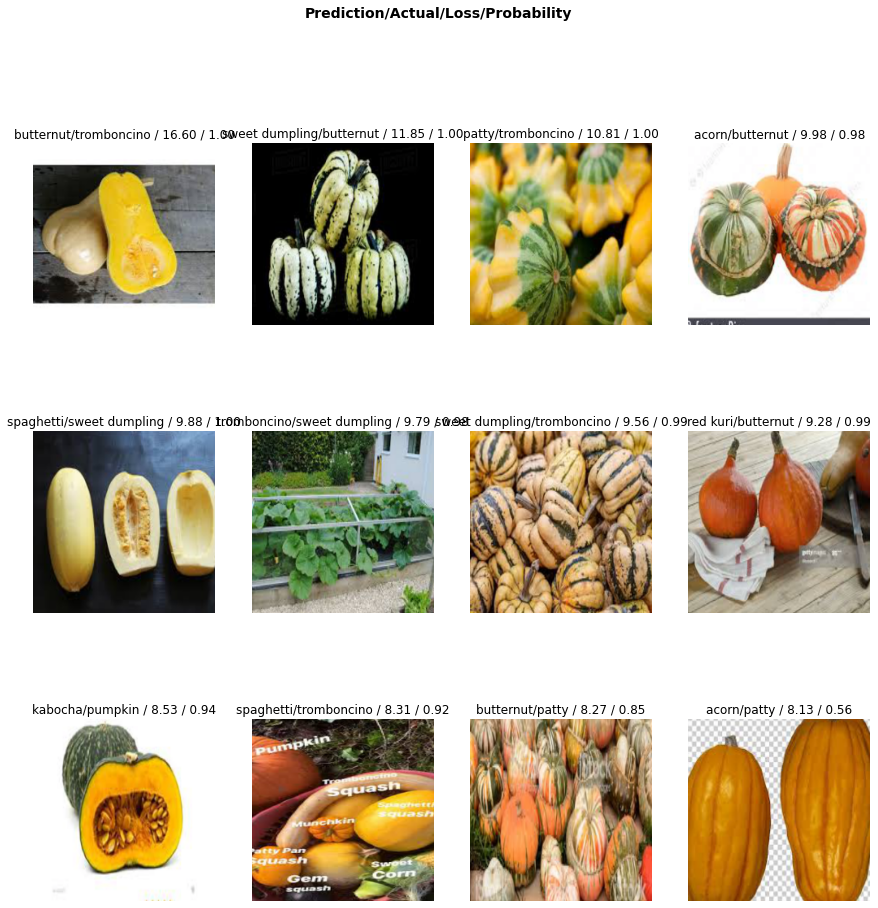

In [24]:
interp.plot_top_losses(12, nrows=3, figsize=(15, 15))

In [67]:
cleaner = ImageClassifierCleaner(learner, max_n=200)
cleaner

In [ ]:
ImageClassifierCleaner??

In [76]:
shutil.move?

In [79]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()

In [74]:
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)
    

In [80]:
# Let's see if getting rid of some of the noise helps things:
loaders = squash.dataloaders(path)

In [81]:
learner = cnn_learner(loaders, resnet34, metrics=error_rate)

In [82]:
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.454524,0.643596,0.196629,02:28


epoch,train_loss,valid_loss,error_rate,time
0,0.853510,0.492953,0.151685,03:27
1,0.628135,0.438368,0.103933,03:26
2,0.475227,0.427402,0.112360,03:26
3,0.372707,0.416957,0.112360,03:25


In [85]:
# export the model parameters:
learner.export()

In [86]:
# Check to see if the model was exported:
path.ls(file_exts='.pkl')

(#0) []